**Objective:**


* Identify temporal patterns in the Emergency Department (ED) volume of patients

* Develop a model to predict ED volum

**Time Series Data:**

* Daily number of patients visiting an emergency department of a hospital in the Atlanta area with observations from 2010 until mid 2015

* Other predicting variables were made available by the hospital but we will only focus on the predictability of the time series with respect to temporal factors

# 1.  Data transformation

In [21]:
## Read data in R
edvoldata = read.csv("EGDailyVolume.xls", header = TRUE)
head(edvoldata)

Year,Month,Day,Volume
<int>,<int>,<int>,<int>
2010,1,1,135
2010,1,2,163
2010,1,3,139
2010,1,4,139
2010,1,5,122
2010,1,6,119


In [22]:
## Process Dates 
year = edvoldata$Year
month = edvoldata$Month
day = edvoldata$Day
datemat = cbind(as.character(day),as.character(month),as.character(year))
paste.dates = function(date){
    day = date[1]; month=date[2]; year = date[3]
    return(paste(day,month,year,sep="/"))
 }
dates = apply(datemat,1,paste.dates) #1 perform on rows
dates = as.Date(dates, format="%d/%m/%Y")

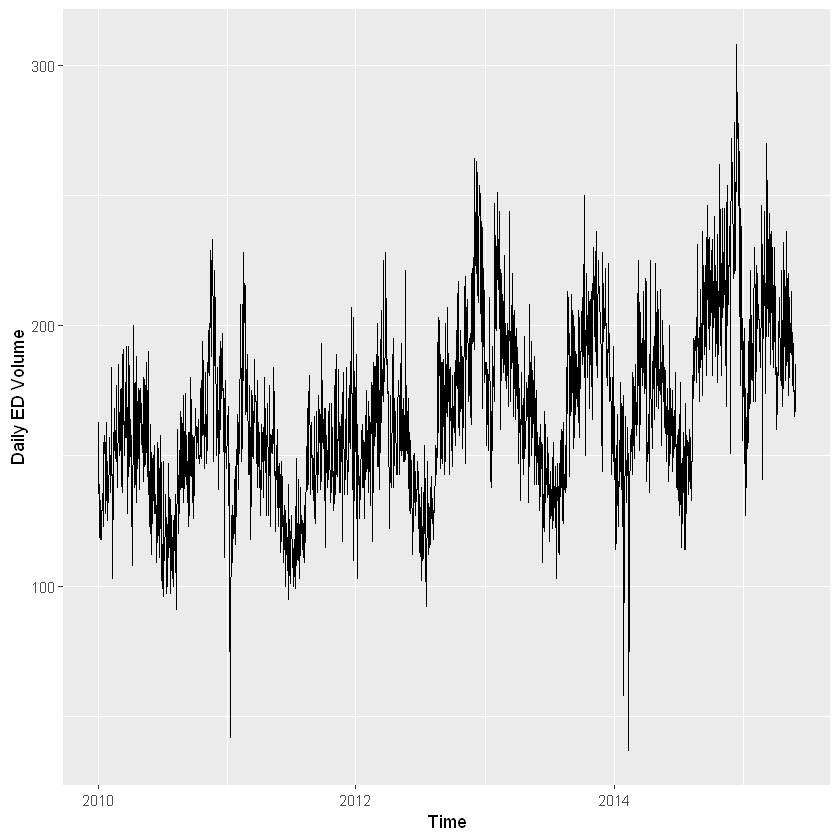

In [89]:
## ## Plot the time series
library(ggplot2)
ggplot(edvoldata, aes(dates, Volume)) + geom_line() + xlab("Time") + ylab("Daily ED Volume")

There is some cyclical pattern although might not be a seasonality since it does not repeat at exact periods of time. We can see that there's also some outliers for example beginning of 2011 and in 2014.

Now we check the distribution of volume

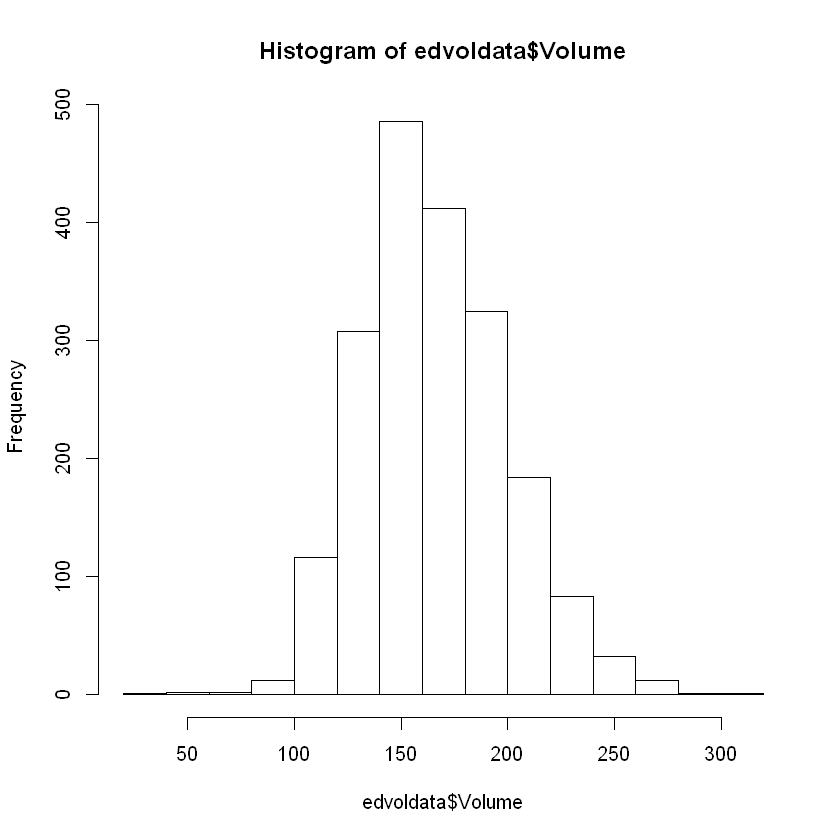

In [33]:
Volume=edvoldata$Volume
hist(edvoldata$Volume)

We see that it's not normal distribution, it's poisson distribution, note that.

* Standard Linear regression model assumes normality
* Variance Stabilizing transformation

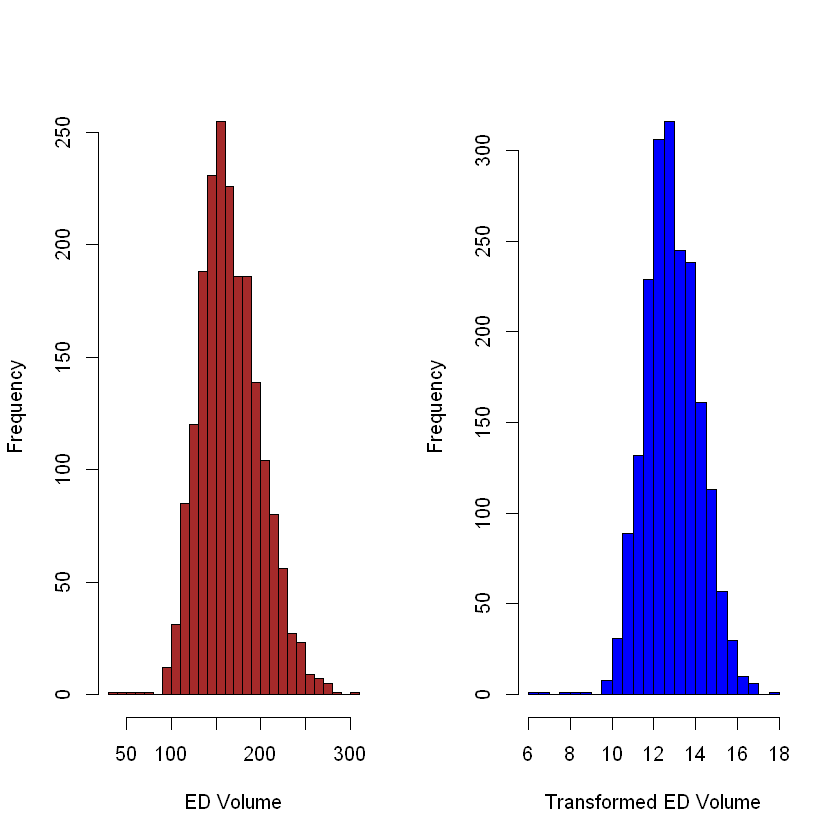

In [36]:
## Apply Transformation
Volume.tr = sqrt(Volume+3/8)
## Compare Distribution
par(mfrow=c(1,2))
hist(Volume,nclass=20,xlab="ED Volume", main="",col="brown")
hist(Volume.tr,nclass=20,xlab= "Transformed ED Volume", main="",col="blue")


# 2. Trend estimation

In [38]:
## set time points
time.pts=c(1:length(Volume))
time.pts=c(time.pts-min(time.pts))/max(time.pts)

Here we use non-parametric trend estimation: local polynomial trend estimation and splines trend estimation, we can see that there are increasing trend in both method.

In [41]:
## Local Polynomial Trend Estimation
loc.fit=loess(Volume.tr~time.pts)
vol.fit.loc=fitted(loc.fit)

## Splines Trend Estimation
library(mgcv)
gam.fit=gam(Volume.tr~s(time.pts))
vol.fit.gam=fitted(gam.fit)

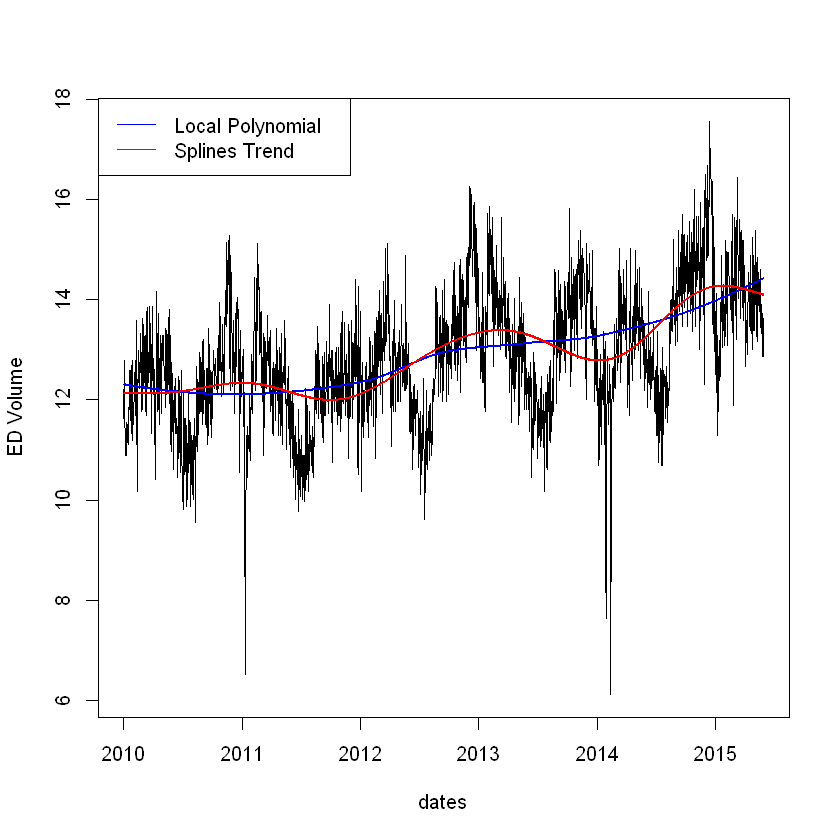

In [57]:
#now check if there's trends
plot(dates,Volume.tr,ylab="ED Volume",type = 'l')
lines(dates,vol.fit.loc,lwd=2,col="blue")
lines(dates,vol.fit.gam,lwd=2,col="red")
legend("topleft",legend = c("Local Polynomial","Splines Trend"),lty=1,col=c("blue","red"))


In [75]:
summary(loc.fit)
print("------------------")
summary(gam.fit)

Call:
loess(formula = Volume.tr ~ time.pts)

Number of Observations: 1977 
Equivalent Number of Parameters: 4.34 
Residual Standard Error: 1.114 
Trace of smoother matrix: 4.72  (exact)

Control settings:
  span     :  0.75 
  degree   :  2 
  family   :  gaussian
  surface  :  interpolate	  cell = 0.2
  normalize:  TRUE
 parametric:  FALSE
drop.square:  FALSE 

[1] "------------------"



Family: gaussian 
Link function: identity 

Formula:
Volume.tr ~ s(time.pts)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.85769    0.02441   526.7   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 8.628   8.96 93.09  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.296   Deviance explained = 29.9%
GCV =  1.184  Scale est. = 1.1782    n = 1977

For the Splines Trend summary we see that T

* The p value for the statistical significance of the smooth term of the trend is statistically significant, indicating a statistically non-constant trend.

* the adjusted R-squared is 0.296, implying that about 30% of the variability in the ED Volume is explained by the trend alone.

so we try to add the seasonality to the data, first we try with monthly seasonality

In [76]:
## Model Trend + Monthly Seasonality
month = as.factor(format(dates,"%b"))
gam.fit.seastr.1 = gam(Volume.tr~s(time.pts)+month-1)
summary(gam.fit.seastr.1)


Family: gaussian 
Link function: identity 

Formula:
Volume.tr ~ s(time.pts) + month - 1

Parametric coefficients:
         Estimate Std. Error t value Pr(>|t|)    
monthApr 12.86352    0.06200   207.5   <2e-16 ***
monthAug 12.36282    0.06656   185.7   <2e-16 ***
monthDec 13.79996    0.06630   208.1   <2e-16 ***
monthFeb 13.19839    0.06392   206.5   <2e-16 ***
monthJan 12.26440    0.06159   199.1   <2e-16 ***
monthJul 11.32858    0.06643   170.5   <2e-16 ***
monthJun 11.85731    0.06738   176.0   <2e-16 ***
monthMar 13.48473    0.06083   221.7   <2e-16 ***
monthMay 12.91504    0.06159   209.7   <2e-16 ***
monthNov 13.80485    0.06751   204.5   <2e-16 ***
monthOct 13.27839    0.06656   199.5   <2e-16 ***
monthSep 13.09015    0.06769   193.4   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
              edf Ref.df     F p-value    
s(time.pts) 8.777  8.985 140.5  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**'

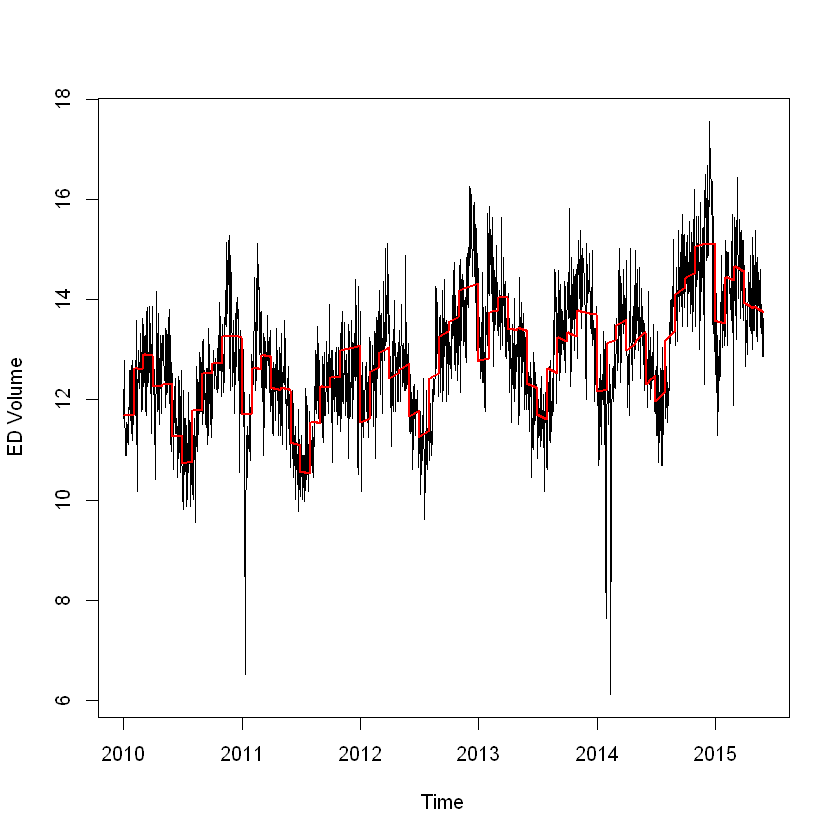

In [90]:
vol.fit.gam.seastr.1 = fitted(gam.fit.seastr.1)
#ggplot(edvoldata, aes(dates, Volume.tr)) + geom_line() + xlab("Time") + ylab("Transformed Daily ED Volume")
plot(dates,Volume.tr,xlab="Time",ylab="ED Volume",type = 'l')
lines(dates,vol.fit.gam.seastr.1,lwd=2,col="red")

We can see that the fitted value are a step function, the fitted line in red doesn't capture the trend. However, the seasonality shows differences from the observed data in some places for some periods of time, indicating that there may be more of a cyclical pattern than a monthly seasonality.

so we try day of the week data, we expected to see that maybe on Sunday we would see a higher volume in the ED.


Family: gaussian 
Link function: identity 

Formula:
Volume.tr ~ s(time.pts) + month + week

Parametric coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   12.77772    0.07383 173.063  < 2e-16 ***
monthAug      -0.50061    0.08852  -5.655 1.79e-08 ***
monthDec       0.93273    0.08791  10.611  < 2e-16 ***
monthFeb       0.33589    0.08509   3.948 8.17e-05 ***
monthJan      -0.59767    0.08365  -7.145 1.26e-12 ***
monthJul      -1.53530    0.08831 -17.385  < 2e-16 ***
monthJun      -1.00553    0.08880 -11.324  < 2e-16 ***
monthMar       0.61815    0.08272   7.472 1.18e-13 ***
monthMay       0.05271    0.08272   0.637  0.52403    
monthNov       0.94163    0.08900  10.580  < 2e-16 ***
monthOct       0.41557    0.08849   4.696 2.84e-06 ***
monthSep       0.22391    0.08935   2.506  0.01229 *  
weekMonday     0.57169    0.06647   8.601  < 2e-16 ***
weekSaturday   0.04589    0.06641   0.691  0.48967    
weekSunday     0.17538    0.06641   2.641  0.00834 ** 
w

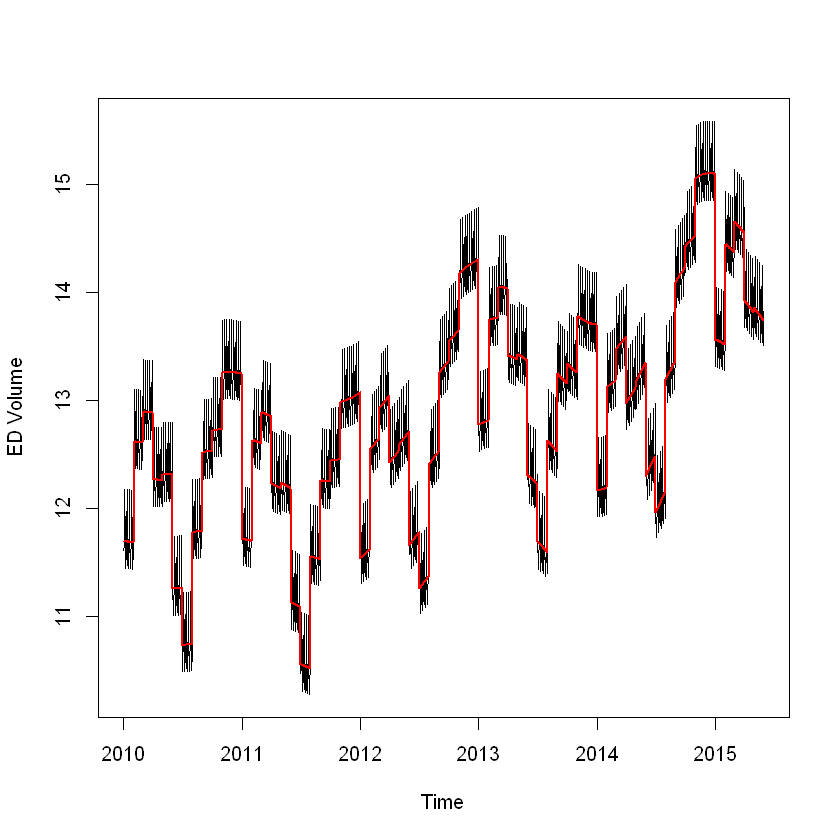

In [96]:
## Add day-of-the-week seasonality
week = as.factor(weekdays(dates))
gam.fit.seastr.2 = gam(Volume.tr~s(time.pts)+month+week)
summary(gam.fit.seastr.2)
vol.fit.gam.seastr.2 = fitted(gam.fit.seastr.2)
## Compare the two fits
plot(dates,vol.fit.gam.seastr.2,xlab="Time",ylab="ED Volume",type = 'l')
lines(dates,vol.fit.gam.seastr.1,lwd=2,col="red")


Here the R-square raise from 0.3 of only the trend is added to the model to 0.62% when we add month and weekday seasonality to the data

In [106]:
## ## Does the addition of seasonality of day of the week adds predictive power?
lm.fit.seastr.1 = lm(Volume.tr~month)
lm.fit.seastr.2 = lm(Volume.tr~month+week)
anova(lm.fit.seastr.1,lm.fit.seastr.2)
##compare them using the partial f test through `anova` in r
plot(dates,lm.fit.seastr.2)

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1965,2169.875,NA,NA,NA,NA
1959,2071.048,6,98.82605,15.57989,1.543093e-17


ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


compare them using the partial f test through `anova` in r. The p value of the test is very small, indicating that we reject the null hypothesis that the simpler model with monthly seasonality only, is as good as the one with both layers of seasonality, suggesting that both monthly seasonality and day of the week seasonality are predictive.

now we compare the seasonality with trend

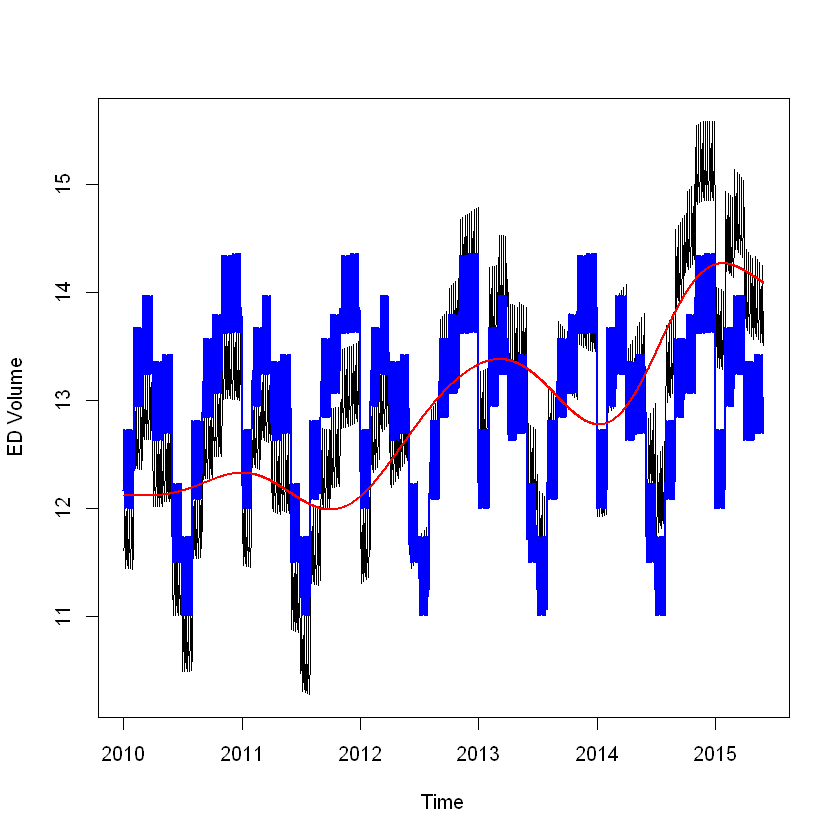

In [109]:
plot(dates,vol.fit.gam.seastr.2,xlab="Time",ylab="ED Volume",type = 'l')
vol.fit.lm.seastr.2=fitted(lm.fit.seastr.2)
lines(dates,vol.fit.lm.seastr.2,lwd=2,col="blue")
lines(dates,vol.fit.gam,lwd=2,col="red")


* black is the full model
* blue only consider seasonality
* red only consider trend

Therefore we can say that the full model explain best of the nonstationary components of the time series represented by ED

# 3. Stationarity

In [110]:
## Residual Process: Trend Removal
resid.1 = Volume.tr-vol.fit.gam
## Residual Process: Stationarity (seasonality) Removal 
resid.2 = Volume.tr-vol.fit.lm.seastr.2
## Residual Process: Trend  and Stationarity Removal 
resid.3 = Volume.tr-vol.fit.gam.seastr.2

In [111]:
y.min = min(c(resid.1,resid.2,resid.3))
y.max = max(c(resid.1,resid.2,resid.3))

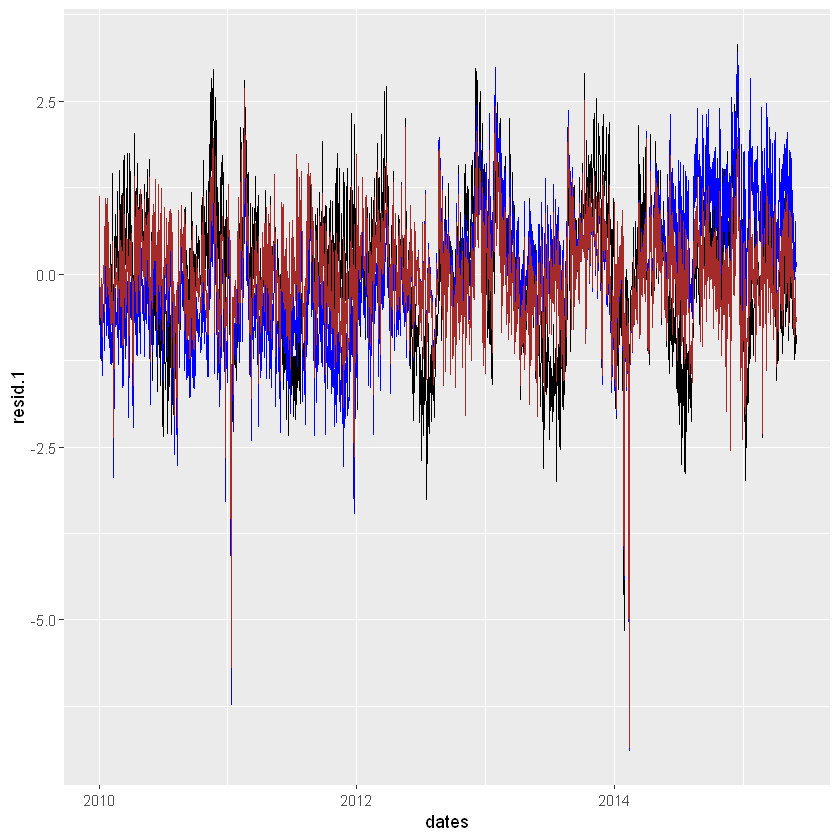

In [117]:
ggplot(edvoldata,aes(x=dates,y=resid.1),ymin=y.min,ymax=y.max)+
    geom_line()+
    geom_line(aes(y=resid.2),color="blue")+
    geom_line(aes(y=resid.3),color="brown")

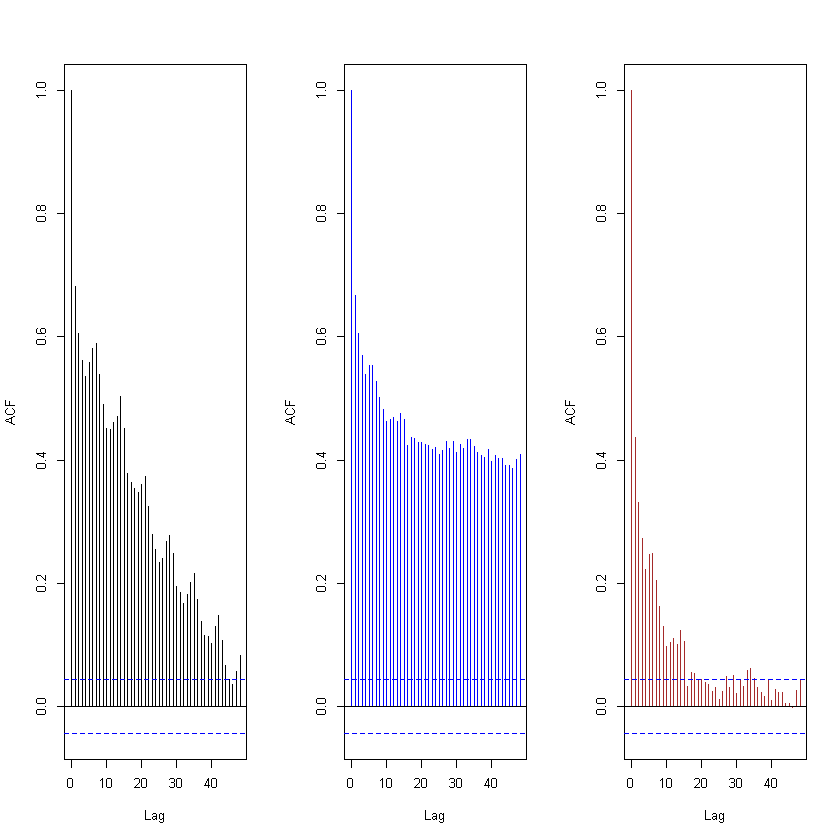

In [130]:
## Compare Auto-correlation plots
par(mfrow = c(1,3))
acf(resid.1,lag.max=12*4,main="")
acf(resid.2,lag.max=12*4,main="",col="blue")
acf(resid.3,lag.max=12*4,main="",col="brown")

Comparing the  auto-correlation plot

1. for the residual time series after removing only the trend

An indication of non-stationarity is that the sample autocorrelation is large, or outside of significance bands, for many large lags. Moreover, we can see a pattern of ups and downs, an indication of seasonality.

2. after removing only the seasonality

While we do not see the cyclical, or the seasonal pattern in the ACF values, the sample auto-correlation decreases slowly. An indication of the presence of a trend in this process.

3. last is the ACF plot removing the seasonality and the trend
The sample ACF values clearly decrease faster than for
the previous residual time series with small values within the significance band, starting around the lag 15. This is an indication of possibly a stationary process.

# 4. Summary from the data

* There is a significant increasing trend in the Emergency Department (ED) patient volume over the past five years 

* Seasonality is more complex; both monthly and day-of-the-week are statistically significant seasonality 

* There are cyclical patterns that may not be fully captured by seasonality; other cyclical factors such as flu season or school season may explain the cyclical pattern